In [1]:
# we use pandas for data preprocessing
import pandas as pd
import numpy as np


# plot data
import matplotlib.pyplot as plt
import seaborn as sns

# we need split API from sklearn to split the data set into train/test
from sklearn.model_selection import train_test_split

# we need to Load libraries and use Tree model
from sklearn.tree import DecisionTreeClassifier

# we also need scikit-learn metrics module for accuracy calculation
from sklearn import metrics        

In [2]:
# load in the transfer fee data into dataframe
# file_path = C:\Users\tycho\Downloads
df = pd.read_csv(r'final_data.csv')
transfer = df[['current_value', 'height', 'age', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'games_injured', 'award']]
# first 5 rows
# display(transfer.head())

# print("Dataset shape: ",transfer.shape)
# print("\nData Types:\n", transfer.dtypes)
# missing_values = transfer.isnull().sum()
# print("\nMissing values:\n", missing_values)
print("\nDescriptive Statistics:\n", transfer.describe())


Descriptive Statistics:
        current_value        height           age         goals       assists  \
count   1.075400e+04  10754.000000  10754.000000  10754.000000  10754.000000   
mean    3.622971e+06    181.240353     26.041903      0.125554      0.086978   
std     9.095410e+06      6.969818      4.777629      0.235585      0.143351   
min     0.000000e+00    156.000000     15.000000      0.000000      0.000000   
25%     3.000000e+05    176.000000     22.000000      0.000000      0.000000   
50%     8.000000e+05    181.240353     26.000000      0.045969      0.040773   
75%     3.000000e+06    186.000000     29.000000      0.172263      0.133136   
max     1.800000e+08    206.000000     43.000000     11.250000      4.000000   

       yellow cards  second yellow cards     red cards  goals conceded  \
count  10754.000000         10754.000000  10754.000000    10754.000000   
mean       0.189757             0.004666      0.006826        0.131655   
std        0.432388            

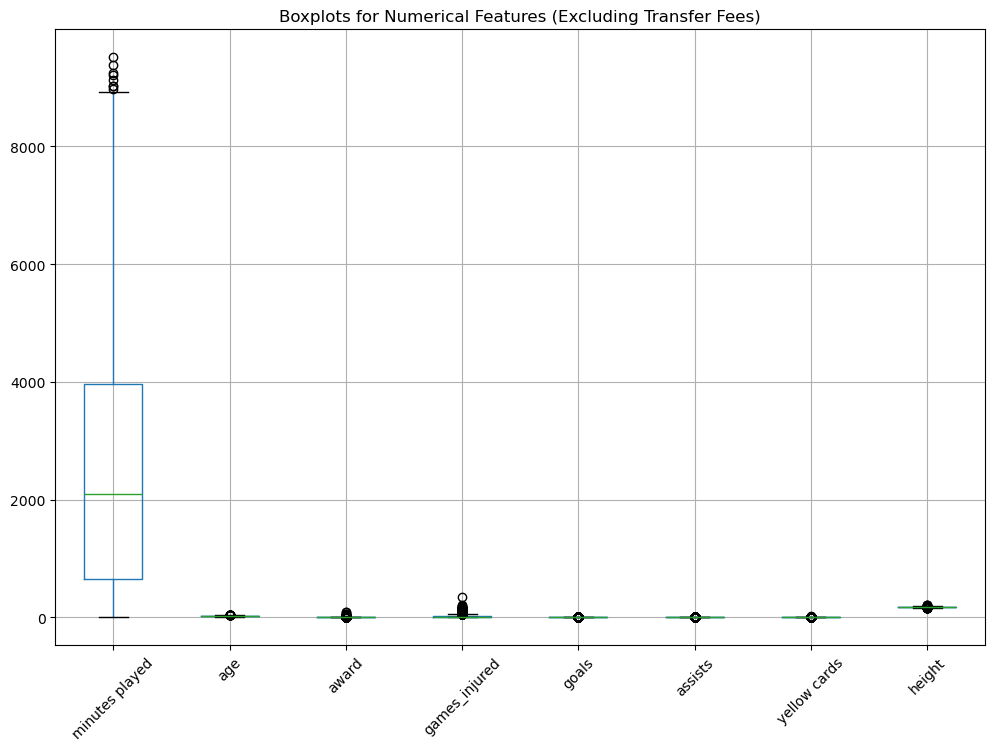

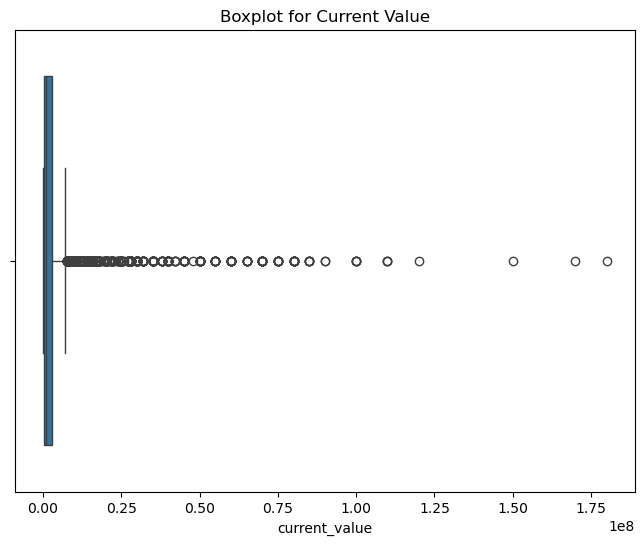

In [3]:
transfer_fee_columns = ['current_value']
other_columns = ['minutes played', 'age', 'award', 'games_injured', 'goals', 'assists', 'yellow cards', 'height']
# Boxplots for other columns
plt.figure(figsize=(12, 8))
transfer[other_columns].boxplot()
plt.title("Boxplots for Numerical Features (Excluding Transfer Fees)")
plt.xticks(rotation=45)
plt.show()

# Boxplot for current_value
plt.figure(figsize=(8, 6))
sns.boxplot(data=transfer, x='current_value')
plt.title("Boxplot for Current Value")
plt.show()

# Boxplot for highest_value
#plt.figure(figsize=(8, 6))
#sns.boxplot(data=transfer, x='highest_value')
#plt.title("Boxplot for Highest Value")
#plt.show()

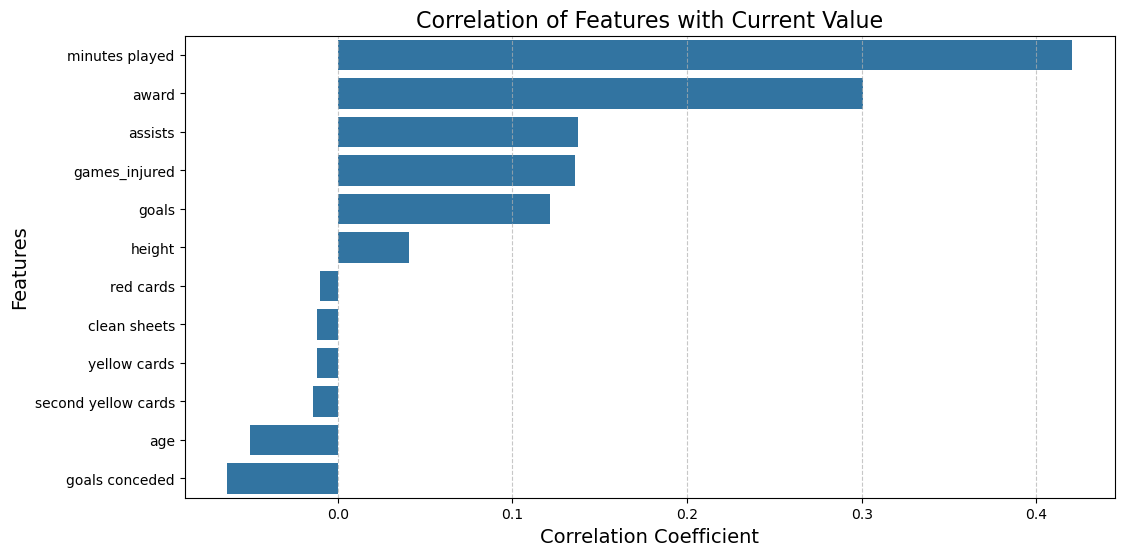

In [4]:
# Compute correlations with the target variable
correlations = transfer.corr()['current_value'].sort_values(ascending=False)

# Drop the correlation of the target variable with itself (1.0)
correlations = correlations.drop('current_value')

# Plot the correlations as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)

# Add labels and title
plt.title('Correlation of Features with Current Value', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Display gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#I only used Features that had a correlation coefficent of 0.1+ to ensure that the model was being trained on relevant data.

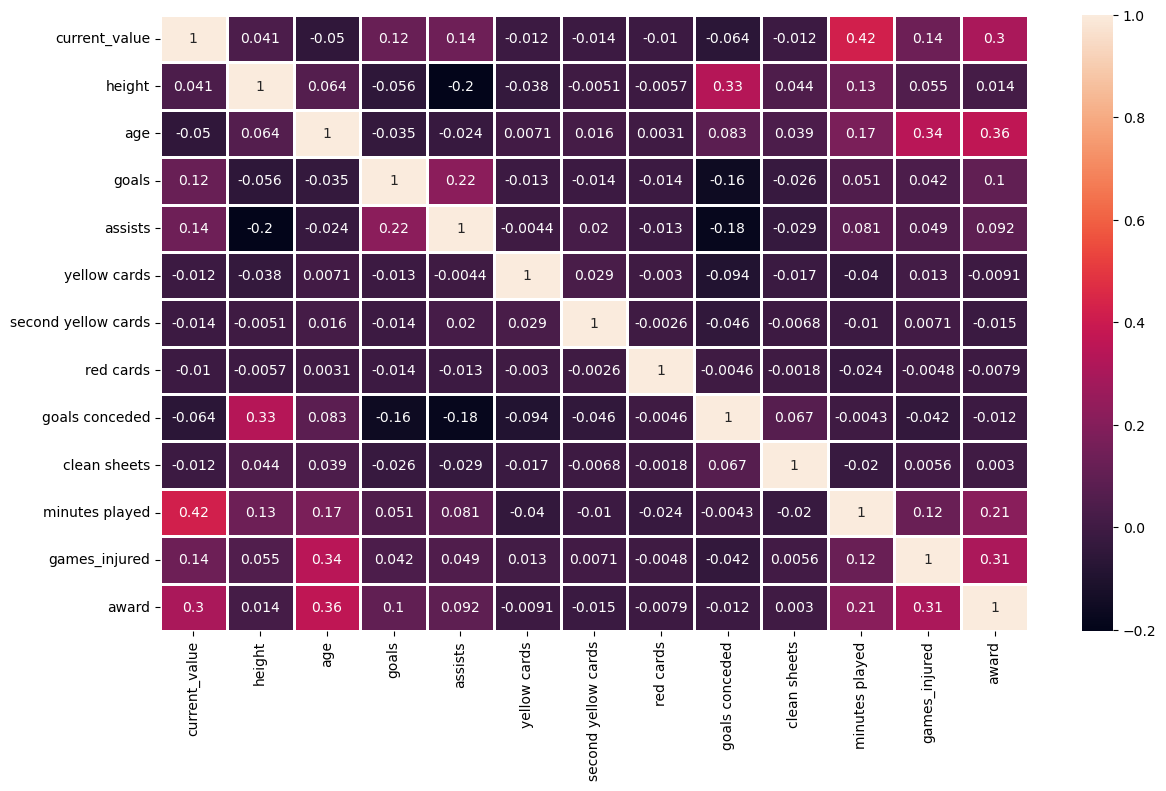

In [5]:
# use a bigger size
plt.figure(figsize=(14, 8))

# correlation heatmap
sns.heatmap(transfer.corr(), annot=True, linewidth =1)

plt.show() 

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

X = transfer[other_columns]
y = transfer['current_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)


cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: [ 0.08363444  0.31836416 -3.04900467 -0.88655403 -7.0380462 ]


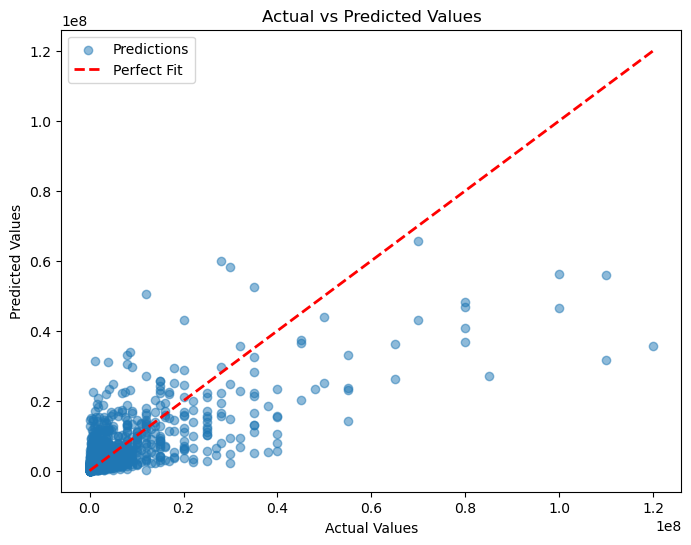

In [7]:
# Predictions from Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Scatter plot for actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],       
    'max_depth': [None, 10, 20],          
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4]         
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,                
    cv=3,                     
    n_jobs=-1,                
    verbose=2,               
    random_state=42           
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.48934238298252347


In [9]:
## Since the optimized Random forest regressor has the best CV score of 0.48,
## we should look if we can optimize it more by looking at the data

transfer_modified = transfer.copy()

# method to cap outliers
def cap_outliers(df, columns):
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)
    return df

columns_to_cap = ['current_value'] + other_columns
transfer_modified = cap_outliers(transfer_modified, columns_to_cap)


X_modified = transfer_modified[other_columns]
y_modified = transfer_modified['current_value']


X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(X_modified, y_modified, test_size=0.2, random_state=42)


param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)


random_search.fit(X_train_modified, y_train_modified)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best CV score: 0.4963020621896619


In [10]:
from sklearn.metrics import mean_squared_error, r2_score

best_rf_model = random_search.best_estimator_

y_pred_test = best_rf_model.predict(X_test_modified)

rmse = np.sqrt(mean_squared_error(y_test_modified, y_pred_test))
r2 = r2_score(y_test_modified, y_pred_test)

print(f"Test Set RMSE: {rmse}")
print(f"Test Set R-squared: {r2}")


Test Set RMSE: 4864826.907087516
Test Set R-squared: 0.5471247446037852


In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [78]:
# Initialize the MLPRegressor model
#ann_model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=1000, random_state=42)
#ann_model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=5000, random_state=42) #45955923847049.41
#ann_model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='lbfgs', max_iter=3000, random_state=42) #171947237566026.78
#ann_model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=4000, random_state=42) #45955923847049.41
#ann_model = MLPRegressor(hidden_layer_sizes=(200, 100, 100), activation='relu', solver='adam', max_iter=4000, random_state=42) #44069801944013.69
ann_model = MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', max_iter=4000, random_state=42) #44069801944013.69

In [80]:
ann_model.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(200, 100), max_iter=4000, random_state=42)

In [81]:
y_pred_ann = ann_model.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming y_test and y_pred_ann are defined
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
mse_ann = rmse_ann**2  # Convert RMSE to MSE
r2_ann = r2_score(y_test, y_pred_ann)

print(f"ANN Test Set RMSE: {rmse_ann}")
print(f"ANN Test Set MSE: {mse_ann}")
print(f"ANN Test Set R-squared: {r2_ann}")



ANN Test Set RMSE: 6726028.834955047
ANN Test Set MSE: 45239463888646.74
ANN Test Set R-squared: 0.49975542135857454


In [84]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define the different hidden_layer_sizes configurations to try
hidden_layer_configs = [
    (100,),          # One hidden layer with 100 neurons
    (200, 100),      # Two hidden layers: 200 and 100 neurons
    (50, 50),        # Two hidden layers: 50 neurons each
    (150, 100, 50),  # Three hidden layers: 150, 100, and 50 neurons
    (250,),          # One hidden layer with 250 neurons
    (100, 50)        # Two hidden layers: 100 and 50 neurons
]

# Placeholder for the best model and score
best_model = None
best_score = float('-inf')
best_config = None

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop through each configuration
for config in hidden_layer_configs:
    # Create and train the model with the current configuration
    model = MLPRegressor(hidden_layer_sizes=config, activation='relu', solver='adam', max_iter=4000, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate R-squared and MSE for evaluation
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Print results for each configuration
    print(f"Hidden Layer Configuration: {config}")
    print(f"  R-squared: {r2}")
    print(f"  MSE: {mse}")
    
    # Update the best model if current configuration is better
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_config = config

# Print out the best model configuration and its R-squared score
print("\nBest Model Configuration:")
print(f"  Hidden Layer Sizes: {best_config}")
print(f"  R-squared: {best_score}")

Hidden Layer Configuration: (100,)
  R-squared: 0.18454813002256987
  MSE: 73745137878278.81
Hidden Layer Configuration: (200, 100)
  R-squared: 0.339884077403263
  MSE: 59697379477333.18
Hidden Layer Configuration: (50, 50)
  R-squared: 0.5013581318583947
  MSE: 45094523259849.76
Hidden Layer Configuration: (150, 100, 50)
  R-squared: 0.40556500224312597
  MSE: 53757545335530.76
Hidden Layer Configuration: (250,)
  R-squared: 0.2910671599425937
  MSE: 64112122322952.32
Hidden Layer Configuration: (100, 50)
  R-squared: 0.3486767378242456
  MSE: 58902217949185.36

Best Model Configuration:
  Hidden Layer Sizes: (50, 50)
  R-squared: 0.5013581318583947
